## Scaling for the 1D model


In [1]:
import cmocean as cmo
import numpy as np  
import matplotlib.gridspec as gspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns
import scipy.stats

%matplotlib inline

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [3]:
# Plots appearance
sns.set_context('talk')
sns.set_style('whitegrid')

In [25]:
def timesteppingKv(IC, KK, dt, dz, maxt):
    '''Iterate for nt timesteps the solution to the diffusion equation with variable Kv
    INPUT
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    rhok = np.copy(IC)  
    for t in np.arange(dt, maxt, dt):
        newrho = rhok[1:-1] + dt/dz**2 * (KK[0:-1] * rhok[0:-2] - 
                                         (KK[0:-1]+KK[1:])*rhok[1:-1] + 
                                             KK[1:]*rhok[2:])
        rhok[1:-1] = newrho
    return(rhok)
# -------------------------------------------------------------------------------------------------------------------
def smoothHS(hdepth, epsilon, Hr, kbg, kcan):
    '''Build smooth Heaviside function at mid-depth points hdepth ''' 
    
    KK = kbg + kcan*(0.5 + 
                     0.5*(hdepth-Hr)/epsilon + 
                     1./(2*np.pi)*np.sin(np.pi*(hdepth-Hr)/(epsilon)))
    KK[hdepth < Hr - epsilon] = kbg
    KK[hdepth >= Hr + epsilon] = kbg + kcan
    return KK
#------------------------------------------------------------------------------------------------------------------------
def initialize(npts, tot_depth, Hr, No=0.5e-2):
    '''
    INPUT
         npts:: int, total number of grid points
    tot_depth:: float, total depth
           Hr:: float, rim depth
           No:: float, inital stratification
    OUTPUT
          dz :: float z spacing
       depth :: array, depths
      hdepth :: array, depths at half grid points 
         rho :: array, initial conditions
    '''
    dz = td/npts
    N = No*np.ones(npts)
    depth = np.arange(0, tot_depth, dz)
    hdepth = depth[:-1]+dz/2.

    rho = 1010 + N**2*1000/10.*depth
    return(dz, depth, hdepth, rho)
#----------------------------------------------------------------------------------------------------------------------
def setup_run(npts, epsilons, kcans, times, run_type):
    '''
    Initialize arrays and set up parameters for a run. Teh idea is to only set up parameters as
    arguments for this function so that I dont make so many silly mistakes.
    INPUT
    npts: number of points to use
    epsilons: float (or array/list if run_type 'epsilon') epsilon value
    kcans: float (or array/list if run_type 'kcan') kcan value
    times: float (or array/list if run_type 'tau') time value
    run_type: string to define what variable will vary in the run,
              'tau' for time, 'eps' for epsilon or kcan for kcan'.
    OUTPUT
    Zero-arrays for C, dCmin, dCmax, Zdif, Zs to pass to the function diffuse and all input parameters. '''
    
    if run_type == 'tau':
        C = np.zeros((len(times), npts))
        dCmin = np.zeros(len(times))
        dCmax = np.zeros(len(times))
        Zdif = np.zeros(len(times))
        Zs = np.zeros(len(times))
        Dz = np.zeros(len(times))
    elif run_type == 'eps':
        C = np.zeros((len(epsilons), npts))
        dCmin = np.zeros(len(epsilons))
        dCmax = np.zeros(len(epsilons))
        Zdif = np.zeros(len(epsilons))
        Zs = np.zeros(len(epsilons))
        Dz = np.zeros(len(epsilons))
    elif run_type == 'kcan':
        C = np.zeros((len(kcans), npts))
        dCmin = np.zeros(len(kcans))
        dCmax = np.zeros(len(kcans))
        Zdif = np.zeros(len(kcans))
        Zs = np.zeros(len(kcans))
        Dz = np.zeros(len(kcans))
    elif run_type == 'kconst':
        C = np.zeros((len(times), npts))
        dCmin = np.zeros(len(times))
        dCmax = np.zeros(len(times))
        Zdif = np.zeros(len(times))
        Zs = np.zeros(len(times))
        Dz = np.zeros(len(times))
    else:
        print('Unrecognized run_type. Try tau, eps or kcan')
    
    return(run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs, Dz)

#-------------------------------------------------------------------------------------------------------------------
def calculate(rho,KK,dt,dz,maxt, time, eps):
    conc = timesteppingKv(rho, KK, dt, dz, maxt)
    dCo = np.mean((rho[1:]-rho[:-1])/dz)
    dCdz = (conc[1:]-conc[:-1])/dz
    mindC = np.min(dCdz/dCo)
    maxdC = np.max(dCdz/dCo)
    dd = int(eps/dz)
    Zdiffusion = ((KK[int(Hr/dz)+dd]-KK[int(Hr/dz)-dd])*time*3600*24)**0.5
    Zscale = ((KK[int(Hr/dz)-dd])*time*3600*24)**0.5
    return(conc, mindC, maxdC, Zdiffusion, Zscale, dd)

# -------------------------------------------------------------------------------------------------------------------
def diffuse(run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs, Dz):
    '''
    Integrate the 1D diffusion equation using the initialized arrays and parameters from setup_run.
    INPUT
    All output from setup_run, as is.
    OUTPUT
    1D arrays of length epsilons, kcans or times, depending on run_type, for C, dCmin, dCmax, 
    Zdif, Zs, dz, depth, hdepth, rho) '''
    
    ii = 0
    if run_type == 'tau':  
        for time in times:
            dt, maxt = 1, 86400*time/1
            dz, depth, hdepth, rho = initialize(npts, td, Hr, No=0.5e-2)
            KK = smoothHS(hdepth, epsilons, Hr, kbg, kcans)
            C[ii,:], dCmin[ii], dCmax[ii], Zdif[ii], Zs[ii], Dz[ii] = calculate(rho,KK,dt,dz,maxt,time,epsilons)
            ii = ii + 1
    
    elif run_type == 'eps':
        for eps in epsilons:
            dt, maxt = 1, 86400*times/1
            dz, depth, hdepth, rho = initialize(npts, td, Hr, No=0.5e-2)
            KK = smoothHS(hdepth, eps, Hr, kbg, kcans)
            C[ii,:], dCmin[ii], dCmax[ii], Zdif[ii], Zs[ii], Dz[ii] = calculate(rho,KK,dt,dz,maxt, times, eps)
            ii = ii + 1
    
    elif run_type == 'kcan':
        for kcan in kcans:
            dt, maxt = 1, 86400*times/1
            dz, depth, hdepth, rho = initialize(npts, td, Hr, No=0.5e-2)
            KK = smoothHS(hdepth, epsilons, Hr, kbg, kcan)
            C[ii,:], dCmin[ii], dCmax[ii], Zdif[ii], Zs[ii], Dz[ii] = calculate(rho,KK,dt,dz,maxt, times, epsilons)
            ii = ii + 1
    
    elif run_type == 'kconst':  
        for time in times:
            dt, maxt = 1, 86400*time/1
            dz, depth, hdepth, rho = initialize(npts, td, Hr, No=0.5e-2)
            KK = np.ones(np.shape(hdepth))*kcans
            C[ii,:], dCmin[ii], dCmax[ii], Zdif[ii], Zs[ii], Dz[ii] = calculate(rho,KK,dt,dz,maxt,time, 1)
            ii = ii + 1
   
    return(C, dCmin, dCmax, Zdif, Dz, Zs, dz, depth, hdepth, rho)

In [5]:
# INITIALIZATION For all runs

sbd = 150.
Hr = 110. # m
td = 2*sbd # total depth
kbg = 1E-5              # background diffusivity

**3 experiments**: tau, epsilon, kcan

Results in arrays C_tau, C_eps, C_kcan

Base case has tau=6 days, epsilon=10 m, kcan = 10$^{-3}$ m$^2$s$^{-1}$.

In [26]:
# Tau runs
npts = 1200
times = [1,2,4,6,8,10,12,14,16]
run_type='tau'

#run 1
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs, Dz = setup_run(npts, 10, 1E-3,
                                                                                  times, run_type)
C_tau, dCmin_tau, dCmax_tau, Zdif_tau, Dz_tau, Z_tau, dz, depth, hdepth, rho = diffuse(run_type, npts, 
                                                                                       epsilons, kcans, 
                                                                                       times, C,
                                                                                       dCmin, dCmax, 
                                                                                       Zdif, Zs, Dz)
print('done with run 1')
#run 2
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs, Dz = setup_run(npts, 10, 1E-2, 
                                                                              times, run_type)
C_tau2, dCmin_tau2, dCmax_tau2, Zdif_tau2,Dz_tau2, Z_tau2, dz, depth, hdepth, rho = diffuse(run_type, 
                                                                                            npts, 
                                                                                            epsilons,
                                                                                            kcans, 
                                                                                            times, C, 
                                                                                            dCmin, 
                                                                                            dCmax,
                                                                                            Zdif, Zs, Dz)
print('done with run 2')
#run 3
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs, Dz = setup_run(npts, 30, 1E-3,
                                                                              times, run_type)
C_tau3, dCmin_tau3, dCmax_tau3, Zdif_tau3,Dz_tau3, Z_tau3, dz, depth, hdepth, rho = diffuse(run_type, 
                                                                                            npts, 
                                                                                            epsilons, 
                                                                                            kcans, 
                                                                                            times, C, 
                                                                                            dCmin, 
                                                                                            dCmax, 
                                                                                            Zdif, Zs, Dz)
print('done with run 3')
#run 4
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs, Dz = setup_run(npts, 5, 1E-3, 
                                                                              times, run_type)
C_tau4, dCmin_tau4, dCmax_tau4, Zdif_tau4,Dz_tau4, Z_tau4, dz, depth, hdepth, rho = diffuse(run_type, 
                                                                                            npts, 
                                                                                            epsilons, 
                                                                                            kcans, 
                                                                                            times, C, 
                                                                                            dCmin, 
                                                                                            dCmax, 
                                                                                            Zdif, Zs, Dz)
print('done with run 4')

done with run 1
done with run 2
done with run 3
done with run 4


In [27]:
# Kcan runs
npts = 1200
kcans = [1E-5, 1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2, 1.2E-2]
run_type='kcan'

#run 1
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, 10, kcans,
                                                                                 6, run_type)
C_kcan, dCmin_kcan, dCmax_kcan, Zdif_kcan,Dz_kan, Z_kcan, dz, depth, hdepth, rho = diffuse(run_type,
                                                                                            npts, 
                                                                                            epsilons, 
                                                                                            kcans, 
                                                                                            times, C, 
                                                                                            dCmin, 
                                                                                            dCmax, 
                                                                                            Zdif, Zs,Dz)
print('done with run 1')
#run 2
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, 30, kcans, 
                                                                                 6, run_type)
C_kcan2, dCmin_kcan2, dCmax_kcan2, Zdif_kcan2,Dz_kan2, Z_kcan2, dz,depth,hdepth,rho = diffuse(run_type,
                                                                                              npts, 
                                                                                              epsilons,
                                                                                              kcans, 
                                                                                              times,
                                                                                              C, 
                                                                                              dCmin, 
                                                                                              dCmax, 
                                                                                              Zdif, Zs,Dz)
print('done with run 2')
#run 3
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, 10, kcans,
                                                                                 9, run_type)
C_kcan3, dCmin_kcan3, dCmax_kcan3, Zdif_kcan3,Dz_kan3, Z_kcan3, dz,depth,hdepth,rho = diffuse(run_type,
                                                                                              npts, 
                                                                                              epsilons, 
                                                                                              kcans,
                                                                                              times,
                                                                                              C, dCmin,
                                                                                              dCmax, 
                                                                                              Zdif, Zs,Dz)
print('done with run 3')
#run 4
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, 5, kcans, 
                                                                                 6, run_type)
C_kcan4, dCmin_kcan4, dCmax_kcan4, Zdif_kcan4,Dz_kan4, Z_kcan4, dz, depth,hdepth,rho = diffuse(run_type, 
                                                                                               npts, 
                                                                                               epsilons, 
                                                                                               kcans, 
                                                                                               times,
                                                                                               C, dCmin,
                                                                                               dCmax, 
                                                                                               Zdif, Zs,Dz)
print('done with run 4')

done with run 1
done with run 2
done with run 3
done with run 4


In [28]:
# epsilon runs
npts = 1200
epsilons = [1,5,10,20,30,40,50,60] 
run_type='eps'

#run 1
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, epsilons,
                                                                                  1E-3, 6, 
                                                                                  run_type)
C_eps, dCmin_eps, dCmax_eps, Zdif_eps,Dz_eps, Z_eps, dz, depth, hdepth, rho = diffuse(run_type, npts,
                                                                                       epsilons, kcans,
                                                                                       times, C, 
                                                                                       dCmin, dCmax,
                                                                                       Zdif, Zs,Dz)
print('done with run 1')
#run 2
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, epsilons,
                                                                                  1E-2, 6, 
                                                                                  run_type)
C_eps2, dCmin_eps2, dCmax_eps2, Zdif_eps2,Dz_eps2, Z_eps2, dz, depth, hdepth, rho = diffuse(run_type,
                                                                                            npts, 
                                                                                            epsilons,
                                                                                            kcans,
                                                                                            times,
                                                                                            C, dCmin,
                                                                                            dCmax, 
                                                                                            Zdif, Zs,Dz)
print('done with run 2')
#run 3
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, epsilons,
                                                                                 1E-3, 9, 
                                                                                 run_type)
C_eps3, dCmin_eps3, dCmax_eps3, Zdif_eps3,Dz_eps3, Z_eps3, dz, depth, hdepth, rho = diffuse(run_type,
                                                                                            npts, 
                                                                                            epsilons,
                                                                                            kcans, 
                                                                                            times,
                                                                                            C, dCmin,
                                                                                            dCmax, 
                                                                                            Zdif, Zs,Dz)
print('done with run 3')
#run 4
run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, epsilons,
                                                                                  5E-3, 6, 
                                                                                  run_type)
C_eps4, dCmin_eps4, dCmax_eps4, Zdif_eps4,Dz_eps4, Z_eps4, dz, depth, hdepth, rho = diffuse(run_type,
                                                                                            npts, 
                                                                                            epsilons,
                                                                                            kcans, 
                                                                                            times,
                                                                                            C, dCmin,
                                                                                            dCmax, 
                                                                                            Zdif, Zs,Dz)
print('done with run 4')

done with run 1
done with run 2
done with run 3
done with run 4


In [29]:
# Tau runs
npts = 1200
times = [1,2,4,6,8,10,12,14,16]
run_type='kconst'


run_type, npts, epsilons, kcans, times, C, dCmin, dCmax, Zdif, Zs,Dz = setup_run(npts, 1, 1E-5,
                                                                                 times, run_type)
C_cnt, dCmin_cnt, dCmax_cnt, Zdif_cnt,Dz_cnt, Z_cnt, dz, depth, hdepth, rho = diffuse(run_type, npts, 
                                                                                      epsilons, kcans, 
                                                                                      times, C,
                                                                                      dCmin, dCmax, 
                                                                                      Zdif, Zs,Dz)


### Concentration

Text(0.5,1,'$\\tau=6$ days, $K_{can}=10^{-3}$ m$^2$s$^{-1}$')

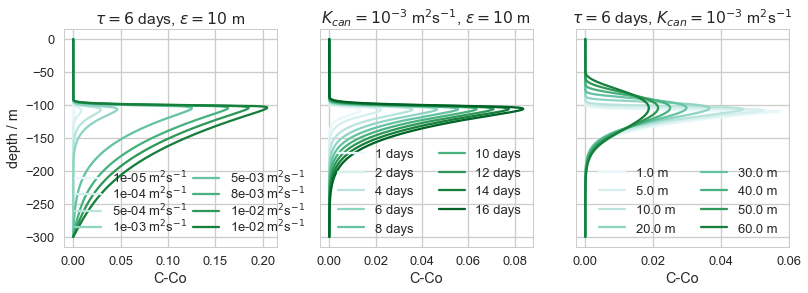

In [31]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(13,4), sharey=True)

times = [1,2,4,6,8,10,12,14,16]
kcans = [1E-5, 1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2, 1.2E-2]
epsilons = [1,5,10,20,30,40,50,60] 

sns.set_palette('BuGn', len(times))

for jj, kk in zip(range(len(kcans)), kcans):
    ax0.plot(C_kcan[jj,:]-rho, -depth, label=(r'%1.0e m$^2$s$^{-1}$' %kk))
ax0.legend(loc=3, ncol=2, labelspacing=0, columnspacing=0.5 )
ax0.set_xlabel('C-Co')
ax0.set_ylabel('depth / m')
ax0.set_title(r'$\tau=6$ days, $\epsilon=10$ m')

for jj, tt in zip(range(len(times)), times):
    ax1.plot(C_tau[jj,:]-rho, -depth, label=('%d days' %tt))
ax1.legend(loc=0, ncol=2)
ax1.set_xlabel('C-Co')
ax1.set_title(r'$K_{can}=10^{-3}$ m$^2$s$^{-1}$, $\epsilon=10$ m')

for jj, kk in zip(range(len(epsilons)), epsilons):
    ax2.plot(C_eps[jj,:]-rho, -depth, label=('%1.1f m' %kk))
ax2.legend(loc=0, ncol=2)
ax2.set_xlabel('C-Co')
ax2.set_title(r'$\tau=6$ days, $K_{can}=10^{-3}$ m$^2$s$^{-1}$')

2.78854576971
2.78854576971
2.78854576971
2.2768252899


Text(0.5,1,'$\\tau=6$ days, $\\epsilon=10$ m')

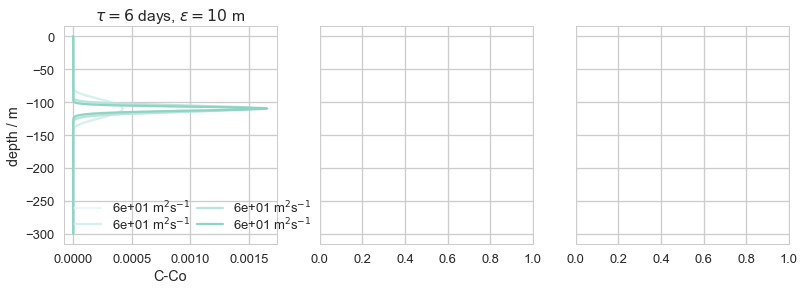

In [32]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(13,4), sharey=True)

kcans = [1E-5, 1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2, 1.2E-2]
epsilons = [1,5,10,20,30,40,50,60] 

sns.set_palette('BuGn', 4)

for C, Zdif in zip([C_kcan[0,:], C_kcan2[0,:], C_kcan3[0,:], C_kcan4[0,:]],
             [Zdif_kcan3[0], Zdif_kcan3[0], Zdif_kcan3[0], Zdif_kcan4[0]]):
    ax0.plot(C[:]-rho, -depth, label=(r'%1.0e m$^2$s$^{-1}$' %kk))
    print(Zdif)
ax0.legend(loc=3, ncol=2, labelspacing=0, columnspacing=0.5 )
ax0.set_xlabel('C-Co')
ax0.set_ylabel('depth / m')
ax0.set_title(r'$\tau=6$ days, $\epsilon=10$ m')


### Max and min dC/dCo 

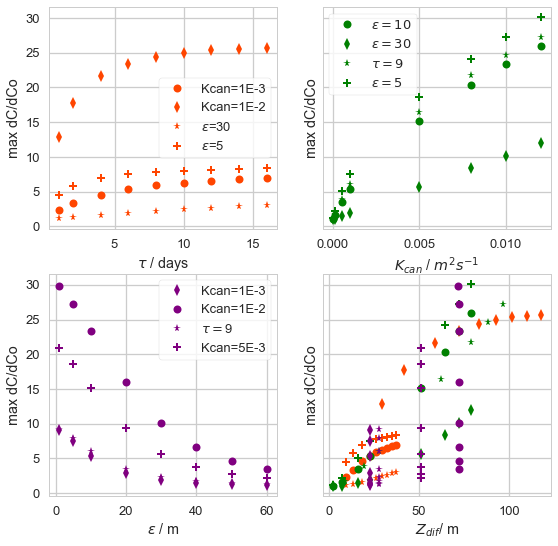

In [33]:
fig, ax = plt.subplots(2,2, figsize=(9,9), sharey=True)

ax[0,0].plot(times, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax[0,0].plot(times, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax[0,0].plot(times, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax[0,0].plot(times, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax[0,1].plot(kcans, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax[0,1].plot(kcans, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax[0,1].plot(kcans, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax[0,1].plot(kcans, dCmax_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax[1,0].plot(epsilons, dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax[1,0].plot(epsilons, dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax[1,0].plot(epsilons, dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax[1,0].plot(epsilons, dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax[1,1].plot(Zdif_tau, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax[1,1].plot(Zdif_tau2, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax[1,1].plot(Zdif_tau3, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax[1,1].plot(Zdif_tau4, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax[1,1].plot(Zdif_kcan, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax[1,1].plot(Zdif_kcan2, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax[1,1].plot(Zdif_kcan3, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax[1,1].plot(Zdif_kcan4, dCmax_kcan4,'P',color='green',markersize=8)

ax[1,1].plot(Zdif_eps, dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax[1,1].plot(Zdif_eps2, dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax[1,1].plot(Zdif_eps3, dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax[1,1].plot(Zdif_eps4, dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax[0,0].set_xlabel(r'$\tau$ / days')
ax[0,0].set_ylabel('max dC/dCo')

ax[0,1].set_xlabel(r'$K_{can}$ / $m^{2}s^{-1}$')
ax[0,1].set_ylabel('max dC/dCo')

ax[1,0].set_xlabel(r'$\epsilon$ / m')
ax[1,0].set_ylabel('max dC/dCo')

ax[1,1].set_xlabel(r'$Z_{dif}$/ m')
ax[1,1].set_ylabel('max dC/dCo')

ax[0,0].legend(loc=0, frameon=True)
ax[0,1].legend(loc=0, frameon=True)
ax[1,0].legend(loc=0, frameon=True)

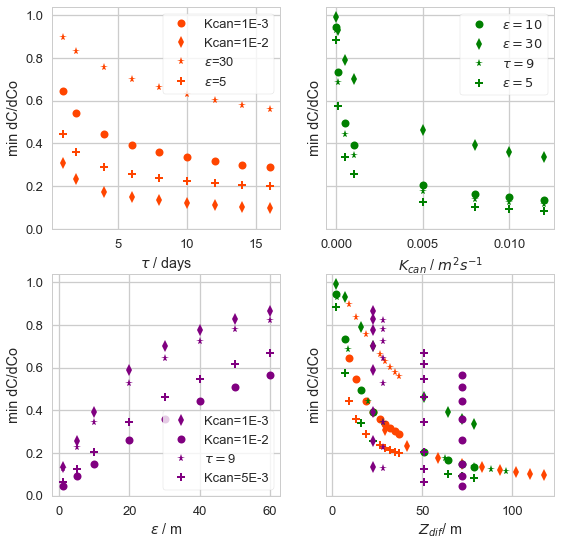

In [34]:
fig, ax = plt.subplots(2,2, figsize=(9,9), sharey=True)

ax[0,0].plot(times, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax[0,0].plot(times, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax[0,0].plot(times, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax[0,0].plot(times, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax[0,1].plot(kcans, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax[0,1].plot(kcans, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax[0,1].plot(kcans, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax[0,1].plot(kcans, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax[1,0].plot(epsilons, dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax[1,0].plot(epsilons, dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax[1,0].plot(epsilons, dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax[1,0].plot(epsilons, dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax[1,1].plot(Zdif_tau, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax[1,1].plot(Zdif_tau2, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax[1,1].plot(Zdif_tau3, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax[1,1].plot(Zdif_tau4, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax[1,1].plot(Zdif_kcan, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax[1,1].plot(Zdif_kcan2, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax[1,1].plot(Zdif_kcan3, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax[1,1].plot(Zdif_kcan4, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax[1,1].plot(Zdif_eps, dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax[1,1].plot(Zdif_eps2, dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax[1,1].plot(Zdif_eps3, dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax[1,1].plot(Zdif_eps4, dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax[0,0].set_xlabel(r'$\tau$ / days')
ax[0,0].set_ylabel('min dC/dCo')

ax[0,1].set_xlabel(r'$K_{can}$ / $m^{2}s^{-1}$')
ax[0,1].set_ylabel('min dC/dCo')

ax[1,0].set_xlabel(r'$\epsilon$ / m')
ax[1,0].set_ylabel('min dC/dCo')

ax[1,1].set_xlabel(r'$Z_{dif}$/ m')
ax[1,1].set_ylabel('min dC/dCo')

ax[0,0].legend(loc=0, frameon=True)
ax[0,1].legend(loc=0, frameon=True)
ax[1,0].legend(loc=0, frameon=True)

### Scale by $Zs = \sqrt{\tau K(above)}$

Text(0,0.5,'max dC/dCo')

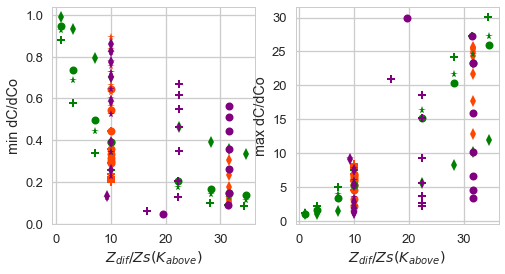

In [35]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

ax0.plot(Zdif_tau/Z_tau, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_tau2/Z_tau2, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_tau3/Z_tau3, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(Zdif_tau4/Z_tau4, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(Zdif_kcan/Z_kcan, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(Zdif_kcan2/Z_kcan2, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(Zdif_kcan3/Z_kcan3, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(Zdif_kcan4/Z_kcan4, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(Zdif_eps/Z_eps, dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_eps2/Z_eps2, dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_eps3/Z_eps3, dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(Zdif_eps4/Z_eps4, dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(Zdif_tau/Z_tau, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_tau2/Z_tau2, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_tau3/Z_tau3, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(Zdif_tau4/Z_tau4, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(Zdif_kcan/Z_kcan, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(Zdif_kcan2/Z_kcan2, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(Zdif_kcan3/Z_kcan3, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(Zdif_kcan4/Z_kcan4, dCmax_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(Zdif_eps/Z_eps, dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_eps2/Z_eps2, dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_eps3/Z_eps3, dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(Zdif_eps4/Z_eps4, dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax0.set_xlabel(r'$Z_{dif}/Zs(K_{above})$')
ax1.set_xlabel(r'$Z_{dif}/Zs(K_{above})$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')


zoomed in

(0, 2)

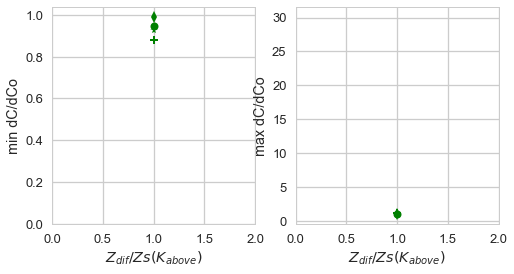

In [36]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

ax0.plot(Zdif_tau/Z_tau, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_tau2/Z_tau2, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_tau3/Z_tau3, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(Zdif_tau4/Z_tau4, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(Zdif_kcan/Z_kcan, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(Zdif_kcan2/Z_kcan2, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(Zdif_kcan3/Z_kcan3, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(Zdif_kcan4/Z_kcan4, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(Zdif_eps/Z_eps, dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_eps2/Z_eps2, dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_eps3/Z_eps3, dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(Zdif_eps4/Z_eps4, dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(Zdif_tau/Z_tau, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_tau2/Z_tau2, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_tau3/Z_tau3, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(Zdif_tau4/Z_tau4, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(Zdif_kcan/Z_kcan, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(Zdif_kcan2/Z_kcan2, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(Zdif_kcan3/Z_kcan3, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(Zdif_kcan4/Z_kcan4, dCmax_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(Zdif_eps/Z_eps, dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_eps2/Z_eps2, dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_eps3/Z_eps3, dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(Zdif_eps4/Z_eps4, dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax0.set_xlabel(r'$Z_{dif}/Zs(K_{above})$')
ax1.set_xlabel(r'$Z_{dif}/Zs(K_{above})$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')
ax0.set_xlim(0,2)
ax1.set_xlim(0,2)

### Scale by $\epsilon$

Text(0,0.5,'max dC/dCo')

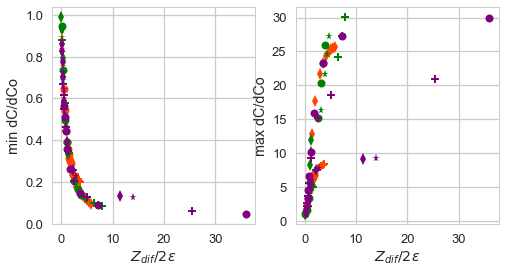

In [37]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

ax0.plot(Zdif_tau/20, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_tau2/20, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_tau3/60, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(Zdif_tau4/10, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(Zdif_kcan/20, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(Zdif_kcan2/60, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(Zdif_kcan3/20, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(Zdif_kcan4/10, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(Zdif_eps/(2*np.array(epsilons)), dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_eps2/(2*np.array(epsilons)), dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_eps3/(2*np.array(epsilons)), dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(Zdif_eps4/(2*np.array(epsilons)), dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(Zdif_tau/20, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_tau2/20, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_tau3/60, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(Zdif_tau4/10, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(Zdif_kcan/20, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(Zdif_kcan2/60, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(Zdif_kcan3/20, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(Zdif_kcan4/10, dCmax_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(Zdif_eps/(2*np.array(epsilons)), dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_eps2/(2*np.array(epsilons)), dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_eps3/(2*np.array(epsilons)), dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(Zdif_eps4/(2*np.array(epsilons)), dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax0.set_xlabel(r'$Z_{dif}/2\epsilon$')
ax1.set_xlabel(r'$Z_{dif}/2\epsilon$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')


zoomed in

(0, 10)

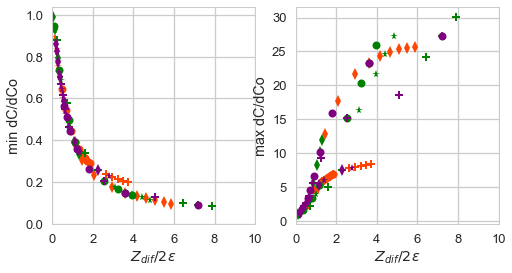

In [38]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

ax0.plot(Zdif_tau/20, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_tau2/20, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_tau3/60, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(Zdif_tau4/10, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(Zdif_kcan/20, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(Zdif_kcan2/60, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(Zdif_kcan3/20, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(Zdif_kcan4/10, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(Zdif_eps/(2*np.array(epsilons)), dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_eps2/(2*np.array(epsilons)), dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_eps3/(2*np.array(epsilons)), dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(Zdif_eps4/(2*np.array(epsilons)), dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(Zdif_tau/20, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_tau2/20, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_tau3/60, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(Zdif_tau4/10, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(Zdif_kcan/20, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(Zdif_kcan2/60, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(Zdif_kcan3/20, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(Zdif_kcan4/10, dCmax_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(Zdif_eps/(2*np.array(epsilons)), dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_eps2/(2*np.array(epsilons)), dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_eps3/(2*np.array(epsilons)), dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(Zdif_eps4/(2*np.array(epsilons)), dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax0.set_xlabel(r'$Z_{dif}/2\epsilon$')
ax1.set_xlabel(r'$Z_{dif}/2\epsilon$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')
ax0.set_xlim(0,10)
ax1.set_xlim(0,10)

### Scale by $\Delta z$ (Distance to calculate $\Delta K$)

In [39]:
max_array = np.concatenate((dCmax_tau,dCmax_tau2, dCmax_tau3, dCmax_tau4,
                            dCmax_kcan, dCmax_kcan2, dCmax_kcan3, dCmax_kcan4,dCmax_eps,
                            dCmax_eps2,dCmax_eps3,dCmax_eps4,dCmax_cnt))

In [40]:
min_array = np.concatenate((dCmin_tau,dCmin_tau2, dCmin_tau3, dCmin_tau4,
                            dCmin_kcan, dCmin_kcan2, dCmin_kcan3, dCmin_kcan4,dCmin_eps,
                            dCmin_eps2,dCmin_eps3,dCmin_eps4,dCmin_cnt))

In [44]:
Zdif_array = np.concatenate((Zdif_tau,Zdif_tau2, Zdif_tau3, Zdif_tau4,
                            Zdif_kcan, Zdif_kcan2, Zdif_kcan3, Zdif_kcan4,Zdif_eps,
                            Zdif_eps2,Zdif_eps3,Zdif_eps4, Zdif_cnt))

In [43]:
Dz_array = np.concatenate((Dz_tau,Dz_tau2, Dz_tau3, Dz_tau4,
                           Dz_kan, Dz_kan2, Dz_kan3, Dz_kan4,Dz_eps,
                           Dz_eps2,Dz_eps3,Dz_eps4, Dz_cnt))

In [71]:
Zdif_small = np.ma.masked_greater(Zdif_array/Dz_array,5)
mask = np.ma.getmask(Zdif_small)
max_array_small = np.ma.masked_array(max_array, mask=mask)
min_array_small = np.ma.masked_array(min_array, mask=mask)


Text(0,0.5,'max dC/dCo')

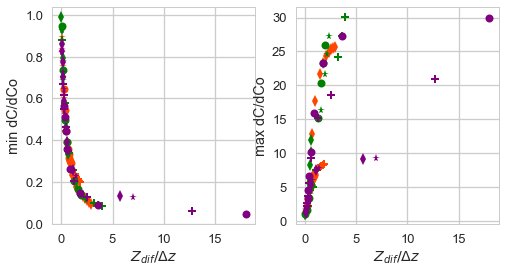

In [65]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

Dz = hdepth[int(Hr/dz)+4]-hdepth[int(Hr/dz)-4]

ax0.plot(Zdif_tau/Dz_tau, dCmin_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_tau2/Dz_tau2, dCmin_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_tau3/Dz_tau3, dCmin_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(Zdif_tau4/Dz_tau4, dCmin_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(Zdif_kcan/Dz_kan, dCmin_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(Zdif_kcan2/Dz_kan2, dCmin_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(Zdif_kcan3/Dz_kan3, dCmin_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(Zdif_kcan4/Dz_kan4, dCmin_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(Zdif_eps/Dz_eps, dCmin_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_eps2/Dz_eps2, dCmin_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_eps3/Dz_eps3, dCmin_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(Zdif_eps4/Dz_eps4, dCmin_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(Zdif_tau/Dz_tau, dCmax_tau,'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_tau2/Dz_tau2, dCmax_tau2,'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_tau3/Dz_tau3, dCmax_tau3,'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(Zdif_tau4/Dz_tau4, dCmax_tau4,'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(Zdif_kcan/Dz_kan, dCmax_kcan,'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(Zdif_kcan2/Dz_kan2, dCmax_kcan2,'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(Zdif_kcan3/Dz_kan3, dCmax_kcan3,'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(Zdif_kcan4/Dz_kan4, dCmax_kcan4,'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(Zdif_eps/Dz_eps, dCmax_eps,'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_eps2/Dz_eps2, dCmax_eps2,'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_eps3/Dz_eps3, dCmax_eps3,'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(Zdif_eps4/Dz_eps4, dCmax_eps4,'P',color='purple',markersize=8, label=r'Kcan=5E-3')


ax0.set_xlabel(r'$Z_{dif}/\Delta z$')
ax1.set_xlabel(r'$Z_{dif}/\Delta z$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')


-0.234596743374 -0.731304232529 -0.697577001743
0.119668116688 1.42840870565 0.254097640296


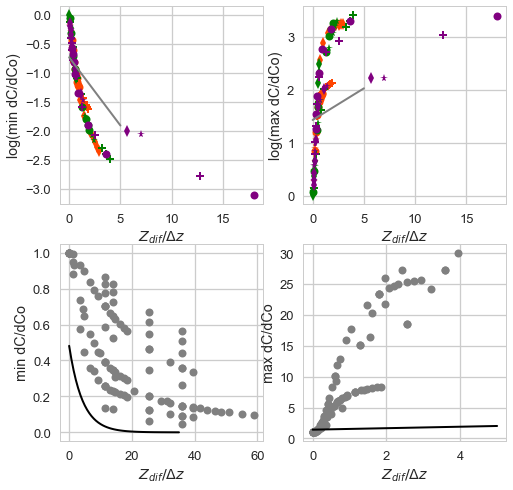

In [67]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize=(8,8))

ax0.plot(Zdif_tau/Dz_tau, np.log(dCmin_tau),'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_tau2/Dz_tau2, np.log(dCmin_tau2),'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_tau3/Dz_tau3, np.log(dCmin_tau3),'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(Zdif_tau4/Dz_tau4, np.log(dCmin_tau4),'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(Zdif_kcan/Dz_kan, np.log(dCmin_kcan),'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(Zdif_kcan2/Dz_kan2, np.log(dCmin_kcan2),'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(Zdif_kcan3/Dz_kan3, np.log(dCmin_kcan3),'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(Zdif_kcan4/Dz_kan4, np.log(dCmin_kcan4),'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(Zdif_eps/Dz_eps, np.log(dCmin_eps),'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(Zdif_eps2/Dz_eps2, np.log(dCmin_eps2),'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(Zdif_eps3/Dz_eps3, np.log(dCmin_eps3),'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(Zdif_eps4/Dz_eps4, np.log(dCmin_eps4),'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(Zdif_tau/Dz_tau, np.log(dCmax_tau),'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_tau2/Dz_tau2, np.log(dCmax_tau2),'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_tau3/Dz_tau3, np.log(dCmax_tau3),'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(Zdif_tau4/Dz_tau4, np.log(dCmax_tau4),'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(Zdif_kcan/Dz_kan,np.log( dCmax_kcan),'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(Zdif_kcan2/Dz_kan2, np.log(dCmax_kcan2),'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(Zdif_kcan3/Dz_kan3, np.log(dCmax_kcan3),'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(Zdif_kcan4/Dz_kan4,np.log( dCmax_kcan4),'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(Zdif_eps/Dz_eps, np.log(dCmax_eps),'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(Zdif_eps2/Dz_eps2, np.log(dCmax_eps2),'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(Zdif_eps3/Dz_eps3, np.log(dCmax_eps3),'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(Zdif_eps4/Dz_eps4, np.log(dCmax_eps4),'P',color='purple',markersize=8, label=r'Kcan=5E-3')

m1, b1, r_1, p_1, std_1 = scipy.stats.linregress(Zdif_array/Dz_array, np.log(min_array))
m2, b2, r_2, p_2, std_2 = scipy.stats.linregress(Zdif_small, np.log(max_array_small))

xx = np.linspace(0,5,50)
fit1 = (xx*m1)+b1
ax0.plot(xx,fit1, '-', color = '0.5', linewidth=2)
print(m1, b1, r_1)

xx2 = np.linspace(0,5,50)
fit2 = (xx2*m2)+b2
ax1.plot(xx2,fit2, '-', color = '0.5', linewidth=2)
print(m2, b2, r_2)

ax0.set_xlabel(r'$Z_{dif}/\Delta z$')
ax1.set_xlabel(r'$Z_{dif}/\Delta z$')
ax0.set_ylabel('log(min dC/dCo)')
ax1.set_ylabel('log(max dC/dCo)')

ax2.plot(Zdif_array/Dz, min_array, 'o',color='0.5', markersize=8)
ax3.plot(Zdif_small, max_array_small, 'o',color='0.5', markersize=8)

ax2.set_xlabel(r'$Z_{dif}/\Delta z$')
ax3.set_xlabel(r'$Z_{dif}/\Delta z$')
ax2.set_ylabel('min dC/dCo')
ax3.set_ylabel('max dC/dCo')

xx = np.linspace(0,35,50)
ax2.plot(xx,np.exp(b1)*np.exp(xx*m1), '-', color = 'k', linewidth=2)
ax3.plot(xx2,b2+(xx2*m2), '-', color = 'k', linewidth=2)


nan nan nan
nan nan nan
2.14285714286


(0, 100)

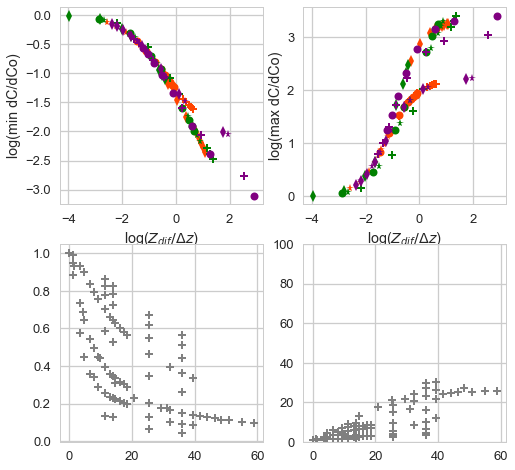

In [63]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize=(8,8))

Dz = hdepth[int(Hr/dz)+4]-hdepth[int(Hr/dz)-4]

ax0.plot(np.log(Zdif_tau/Dz_tau), np.log(dCmin_tau),'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax0.plot(np.log(Zdif_tau2/Dz_tau2), np.log(dCmin_tau2),'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax0.plot(np.log(Zdif_tau3/Dz_tau3), np.log(dCmin_tau3),'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax0.plot(np.log(Zdif_tau4/Dz_tau4), np.log(dCmin_tau4),'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax0.plot(np.log(Zdif_kcan/Dz_kan), np.log(dCmin_kcan),'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax0.plot(np.log(Zdif_kcan2/Dz_kan2), np.log(dCmin_kcan2),'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax0.plot(np.log(Zdif_kcan3/Dz_kan3), np.log(dCmin_kcan3),'*',color='green',markersize=8, label=r'$\tau=9$')
ax0.plot(np.log(Zdif_kcan4/Dz_kan4), np.log(dCmin_kcan4),'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax0.plot(np.log(Zdif_eps/Dz_eps), np.log(dCmin_eps),'d',color='purple',markersize=8, label='Kcan=1E-3')
ax0.plot(np.log(Zdif_eps2/Dz_eps2), np.log(dCmin_eps2),'o',color='purple',markersize=8, label='Kcan=1E-2')
ax0.plot(np.log(Zdif_eps3/Dz_eps3), np.log(dCmin_eps3),'*',color='purple',markersize=8, label=r'$\tau=$9')
ax0.plot(np.log(Zdif_eps4/Dz_eps4), np.log(dCmin_eps4),'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax1.plot(np.log(Zdif_tau/Dz_tau), np.log(dCmax_tau),'o',color='orangered',markersize=8, label='Kcan=1E-3')
ax1.plot(np.log(Zdif_tau2/Dz_tau2), np.log(dCmax_tau2),'d',color='orangered',markersize=8, label='Kcan=1E-2')
ax1.plot(np.log(Zdif_tau3/Dz_tau3), np.log(dCmax_tau3),'*',color='orangered',markersize=8, label=r'$\epsilon$=30')
ax1.plot(np.log(Zdif_tau4/Dz_tau4), np.log(dCmax_tau4),'P',color='orangered',markersize=8, label=r'$\epsilon$=5')

ax1.plot(np.log(Zdif_kcan/Dz_kan), np.log(dCmax_kcan),'o',color='green',markersize=8, label=r'$\epsilon=10$')
ax1.plot(np.log(Zdif_kcan2/Dz_kan2), np.log(dCmax_kcan2),'d',color='green',markersize=8, label=r'$\epsilon=30$')
ax1.plot(np.log(Zdif_kcan3/Dz_kan3), np.log(dCmax_kcan3),'*',color='green',markersize=8, label=r'$\tau=9$')
ax1.plot(np.log(Zdif_kcan4/Dz_kan4), np.log(dCmax_kcan4),'P',color='green',markersize=8, label=r'$\epsilon=5$')

ax1.plot(np.log(Zdif_eps/Dz_eps), np.log(dCmax_eps),'d',color='purple',markersize=8, label='Kcan=1E-3')
ax1.plot(np.log(Zdif_eps2/Dz_eps2), np.log(dCmax_eps2),'o',color='purple',markersize=8, label='Kcan=1E-2')
ax1.plot(np.log(Zdif_eps3/Dz_eps3), np.log(dCmax_eps3),'*',color='purple',markersize=8, label=r'$\tau=$9')
ax1.plot(np.log(Zdif_eps4/Dz_eps4), np.log(dCmax_eps4),'P',color='purple',markersize=8, label=r'Kcan=5E-3')

ax0.set_xlabel(r'log($Z_{dif}/\Delta z$)')
ax1.set_xlabel(r'log($Z_{dif}/\Delta z$)')
ax0.set_ylabel('log(min dC/dCo)')
ax1.set_ylabel('log(max dC/dCo)')

m3, b3, r_3, p_3, std_3 = scipy.stats.linregress(np.log(Zdif_array/Dz_array), np.log(min_array))
m4, b4, r_4, p_4, std_4 = scipy.stats.linregress(np.log(Zdif_array/Dz_array), np.log(max_array))
m5, b5, r_5, p_5, std_5 = scipy.stats.linregress(Zdif_small, max_array_small)

xx = np.linspace(0,3.5,50)
fit3 = (xx*m3)+b3
ax0.plot(xx,fit3, '-', color = '0.5', linewidth=2)
print(m3, b3, r_3)

fit4 = (xx*m4)+b4
ax1.plot(xx,fit4, '-', color = '0.5', linewidth=2)
print(m4, b4, r_4)

xx = np.linspace(0,35,50)
ax2.plot(Zdif_array/Dz, min_array, 'P', color = '0.5', linewidth=2, markersize=8)
ax2.plot(xx,np.exp(b3)*(xx**m3), '-', color = 'k', linewidth=2, markersize=8)
ax2.plot(xx[3],np.exp(b3)*(xx[3]**m3), 'P', color = 'yellow', linewidth=2)

ax3.plot(Zdif_array/Dz, max_array, 'P', color = '0.5', linewidth=2, markersize=8)
ax3.plot(xx,np.exp(b4)*(xx**m4), '-', color = 'k', linewidth=2)

print(xx[3])
ax3.set_ylim(0,100)

2.23204188692


(0, 30)

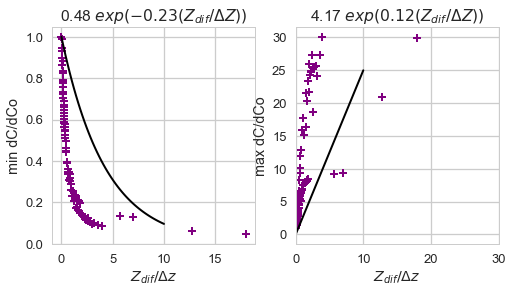

In [75]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

Dz = hdepth[int(Hr/dz)+4]-hdepth[int(Hr/dz)-4]

ax1.plot(Zdif_array/Dz_array, max_array,'P',color='purple',markersize=8)
ax0.plot(Zdif_array/Dz_array, min_array,'P',color='purple',markersize=8)

ax0.set_xlabel(r'$Z_{dif}/\Delta z$')
ax1.set_xlabel(r'$Z_{dif}/\Delta z$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')

m5, b5, r_5, p_5, std_5 = scipy.stats.linregress(Zdif_small, max_array_small)

print(m5)
xx = np.linspace(0,10,50)
ax0.plot(Zdif_array/Dz_array, min_array, 'P', color = 'purple', linewidth=2, markersize=8)
ax0.plot(xx,np.exp(xx*m1), '-', color = 'k', linewidth=2, markersize=8)
ax1.plot(Zdif_array/Dz_array,max_array, 'P', color = 'purple', linewidth=2, markersize=8)
ax1.plot(xx,(xx*2.5), '-', color = 'k', linewidth=2)

ax0.set_title('%1.2f $exp(%1.2f(Z_{dif}/\Delta Z))$' %(np.exp(b1),m1))
ax1.set_title('%1.2f $exp(%1.2f(Z_{dif}/\Delta Z))$' %(np.exp(b2),m2))

ax1.set_xlim(0,30)

In [56]:
m2, b2, r_2, p_2, std_2 = scipy.stats.linregress(Zdif_small.data, np.log(max_array_small.data))
xx2 = np.linspace(0,4,50)

for mm in np.linspace(0.1, 0.5, 100):
    fit0 = ((Zdif_small*mm))
    error = (1/len(fit0))*np.sum((fit0-np.log(max_array_small))**2)
    print(mm, error)
    

0.1 3.23179086354
0.10404040404 3.21401092961
0.108080808081 3.19630587812
0.112121212121 3.17867570906
0.116161616162 3.16112042245
0.120202020202 3.14364001827
0.124242424242 3.12623449654
0.128282828283 3.10890385724
0.132323232323 3.09164810038
0.136363636364 3.07446722596
0.140404040404 3.05736123397
0.144444444444 3.04033012443
0.148484848485 3.02337389732
0.152525252525 3.00649255266
0.156565656566 2.98968609043
0.160606060606 2.97295451064
0.164646464646 2.95629781329
0.168686868687 2.93971599838
0.172727272727 2.92320906591
0.176767676768 2.90677701587
0.180808080808 2.89041984828
0.184848484848 2.87413756312
0.188888888889 2.8579301604
0.192929292929 2.84179764012
0.19696969697 2.82574000228
0.20101010101 2.80975724688
0.205050505051 2.79384937391
0.209090909091 2.77801638339
0.213131313131 2.7622582753
0.217171717172 2.74657504965
0.221212121212 2.73096670645
0.225252525253 2.71543324567
0.229292929293 2.69997466734
0.233333333333 2.68459097145
0.237373737374 2.669282158
0.2

Text(0,0.5,'log(max $N^2/N_0^2$)')

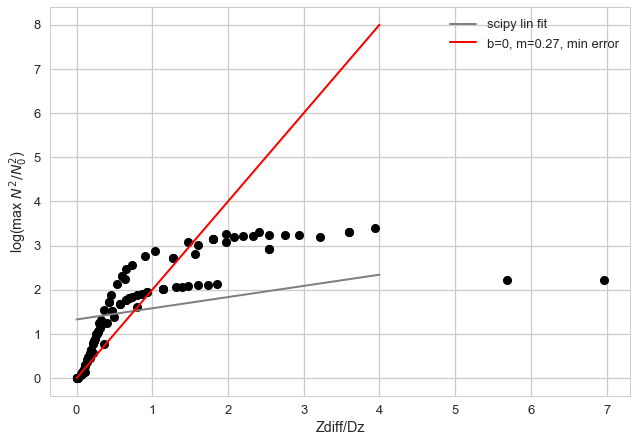

In [58]:
fit2 = (b2+(xx2*m2))
plt.plot(Zdif_small,np.log(max_array_small), 'o', color = 'k', linewidth=2)
plt.plot(xx2,fit2, '-', color = '0.5', linewidth=2, label='scipy lin fit')
plt.plot(xx2,xx2*2, '-', color='red', linewidth=2,label='b=0, m=0.27, min error')
plt.legend(loc=0)
plt.xlabel('Zdiff/Dz')
plt.ylabel('log(max $N^2/N_0^2$)')

Text(0.5,1,'$exp(0.25(Z_{dif}/\\Delta Z))$')

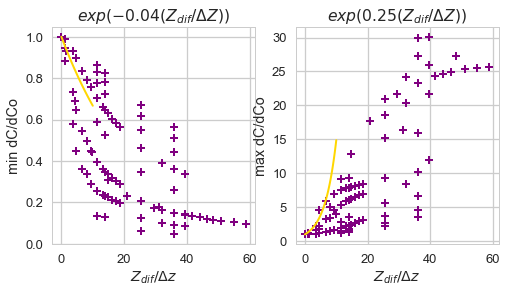

In [54]:
# Give preference to satisfying F(Zdif=0)=1

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))

Dz = hdepth[int(Hr/dz)+4]-hdepth[int(Hr/dz)-4]

ax1.plot(Zdif_array/Dz, max_array,'P',color='purple',markersize=8)
ax0.plot(Zdif_array/Dz, min_array,'P',color='purple',markersize=8)

ax0.set_xlabel(r'$Z_{dif}/\Delta z$')
ax1.set_xlabel(r'$Z_{dif}/\Delta z$')
ax0.set_ylabel('min dC/dCo')
ax1.set_ylabel('max dC/dCo')

xx = np.linspace(0,10,50)
ax0.plot(Zdif_array/Dz, min_array, 'P', color = 'purple', linewidth=2, markersize=8)
ax0.plot(xx,np.exp(xx*m1), '-', color = 'gold', linewidth=2, markersize=8)
ax1.plot(Zdif_array/Dz,max_array, 'P', color = 'purple', linewidth=2, markersize=8)
ax1.plot(xx,np.exp(xx*0.27), '-', color = 'gold', linewidth=2)

ax0.set_title('$exp(%1.2f(Z_{dif}/\Delta Z))$' %(m1))
ax1.set_title('$exp(%1.2f(Z_{dif}/\Delta Z))$' %(m2))


Text(0.5,1,'$\\tau=6$ days, $K_{can}=10^{-3}$ m$^2$s$^{-1}$')

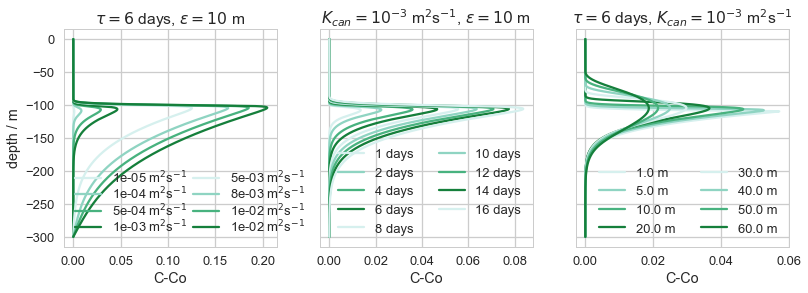

In [55]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(13,4), sharey=True)

times = [1,2,4,6,8,10,12,14,16]
kcans = [1E-5, 1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2, 1.2E-2]
epsilons = [1,5,10,20,30,40,50,60] 

sns.set_palette('BuGn', len(times))

for jj, kk in zip(range(len(kcans)), kcans):
    ax0.plot(C_kcan[jj,:]-rho, -depth, label=(r'%1.0e m$^2$s$^{-1}$' %kk))
ax0.legend(loc=3, ncol=2, labelspacing=0, columnspacing=0.5 )
ax0.set_xlabel('C-Co')
ax0.set_ylabel('depth / m')
ax0.set_title(r'$\tau=6$ days, $\epsilon=10$ m')

for jj, tt in zip(range(len(times)), times):
    ax1.plot(C_tau[jj,:]-rho, -depth, label=('%d days' %tt))
ax1.legend(loc=0, ncol=2)
ax1.set_xlabel('C-Co')
ax1.set_title(r'$K_{can}=10^{-3}$ m$^2$s$^{-1}$, $\epsilon=10$ m')

for jj, kk in zip(range(len(epsilons)), epsilons):
    ax2.plot(C_eps[jj,:]-rho, -depth, label=('%1.1f m' %kk))
ax2.legend(loc=0, ncol=2)
ax2.set_xlabel('C-Co')
ax2.set_title(r'$\tau=6$ days, $K_{can}=10^{-3}$ m$^2$s$^{-1}$')
